# Titanic Project - Kaggle
## Use a dataset from the titanic giving information about passengers in order to predict weather they will survive or not.

In [1]:
#main libraries
import os
import re
import pickle
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf

#machine learning libraries:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks,RandomUnderSampler,NearMiss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, confusion_matrix,plot_confusion_matrix,cohen_kappa_score,accuracy_score,recall_score,precision_score,f1_score,classification_report

# Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

# You can go offline on demand by using
cf.go_offline() 

# To connect java script to your notebook
init_notebook_mode(connected=False)

# set some display options:
plt.rcParams['figure.dpi'] = 100
colors = px.colors.qualitative.Prism
pio.templates.default = "plotly_white"

# see our files:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')
gender=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
# train.columns = [x.lower() for x in train.columns]

# Descriptive Statistics - Glancing from above

In [4]:
data=train
data.head(20)
data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

Next: Checking for NaNs. Notice that three columns have nulls.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


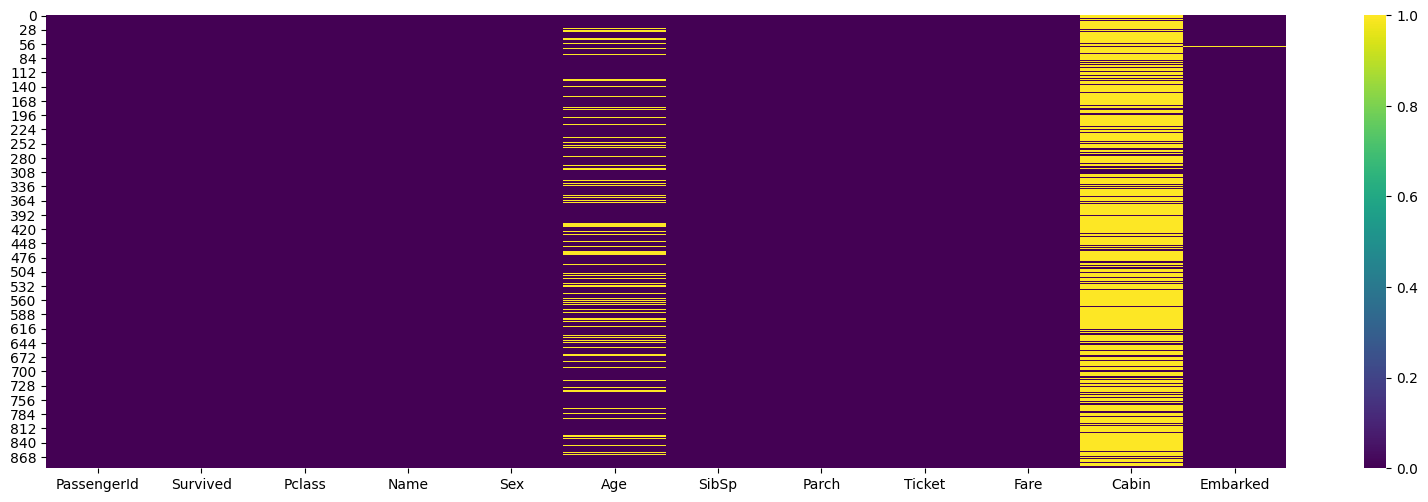

In [5]:
print(data.isnull().sum())

#visuaize the null values in each column
plt.figure(figsize=(20,6));
sns.heatmap(data.isnull(), cmap='viridis');

In [6]:
data['target'] = data['Survived'].map({1:'Survived',0:'Not Survived'})
data['sex'] = data['Sex'].apply(lambda x:x.title()) #title makes the first letter of each word uppercase

In [7]:
datanum=data.select_dtypes(include=np.number)
datanum

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare
0              1         0       3  22.0      1      0   7.2500
1              2         1       1  38.0      1      0  71.2833
2              3         1       3  26.0      0      0   7.9250
3              4         1       1  35.0      1      0  53.1000
4              5         0       3  35.0      0      0   8.0500
..           ...       ...     ...   ...    ...    ...      ...
886          887         0       2  27.0      0      0  13.0000
887          888         1       1  19.0      0      0  30.0000
888          889         0       3   NaN      1      2  23.4500
889          890         1       1  26.0      0      0  30.0000
890          891         0       3  32.0      0      0   7.7500

[891 rows x 7 columns]

In [8]:
# data=data.drop('Name',axis=1)
data=data.drop('PassengerId',axis=1)

# Exploratory Data Analysis EDA

## Getting a sense of the data, Data Exploration

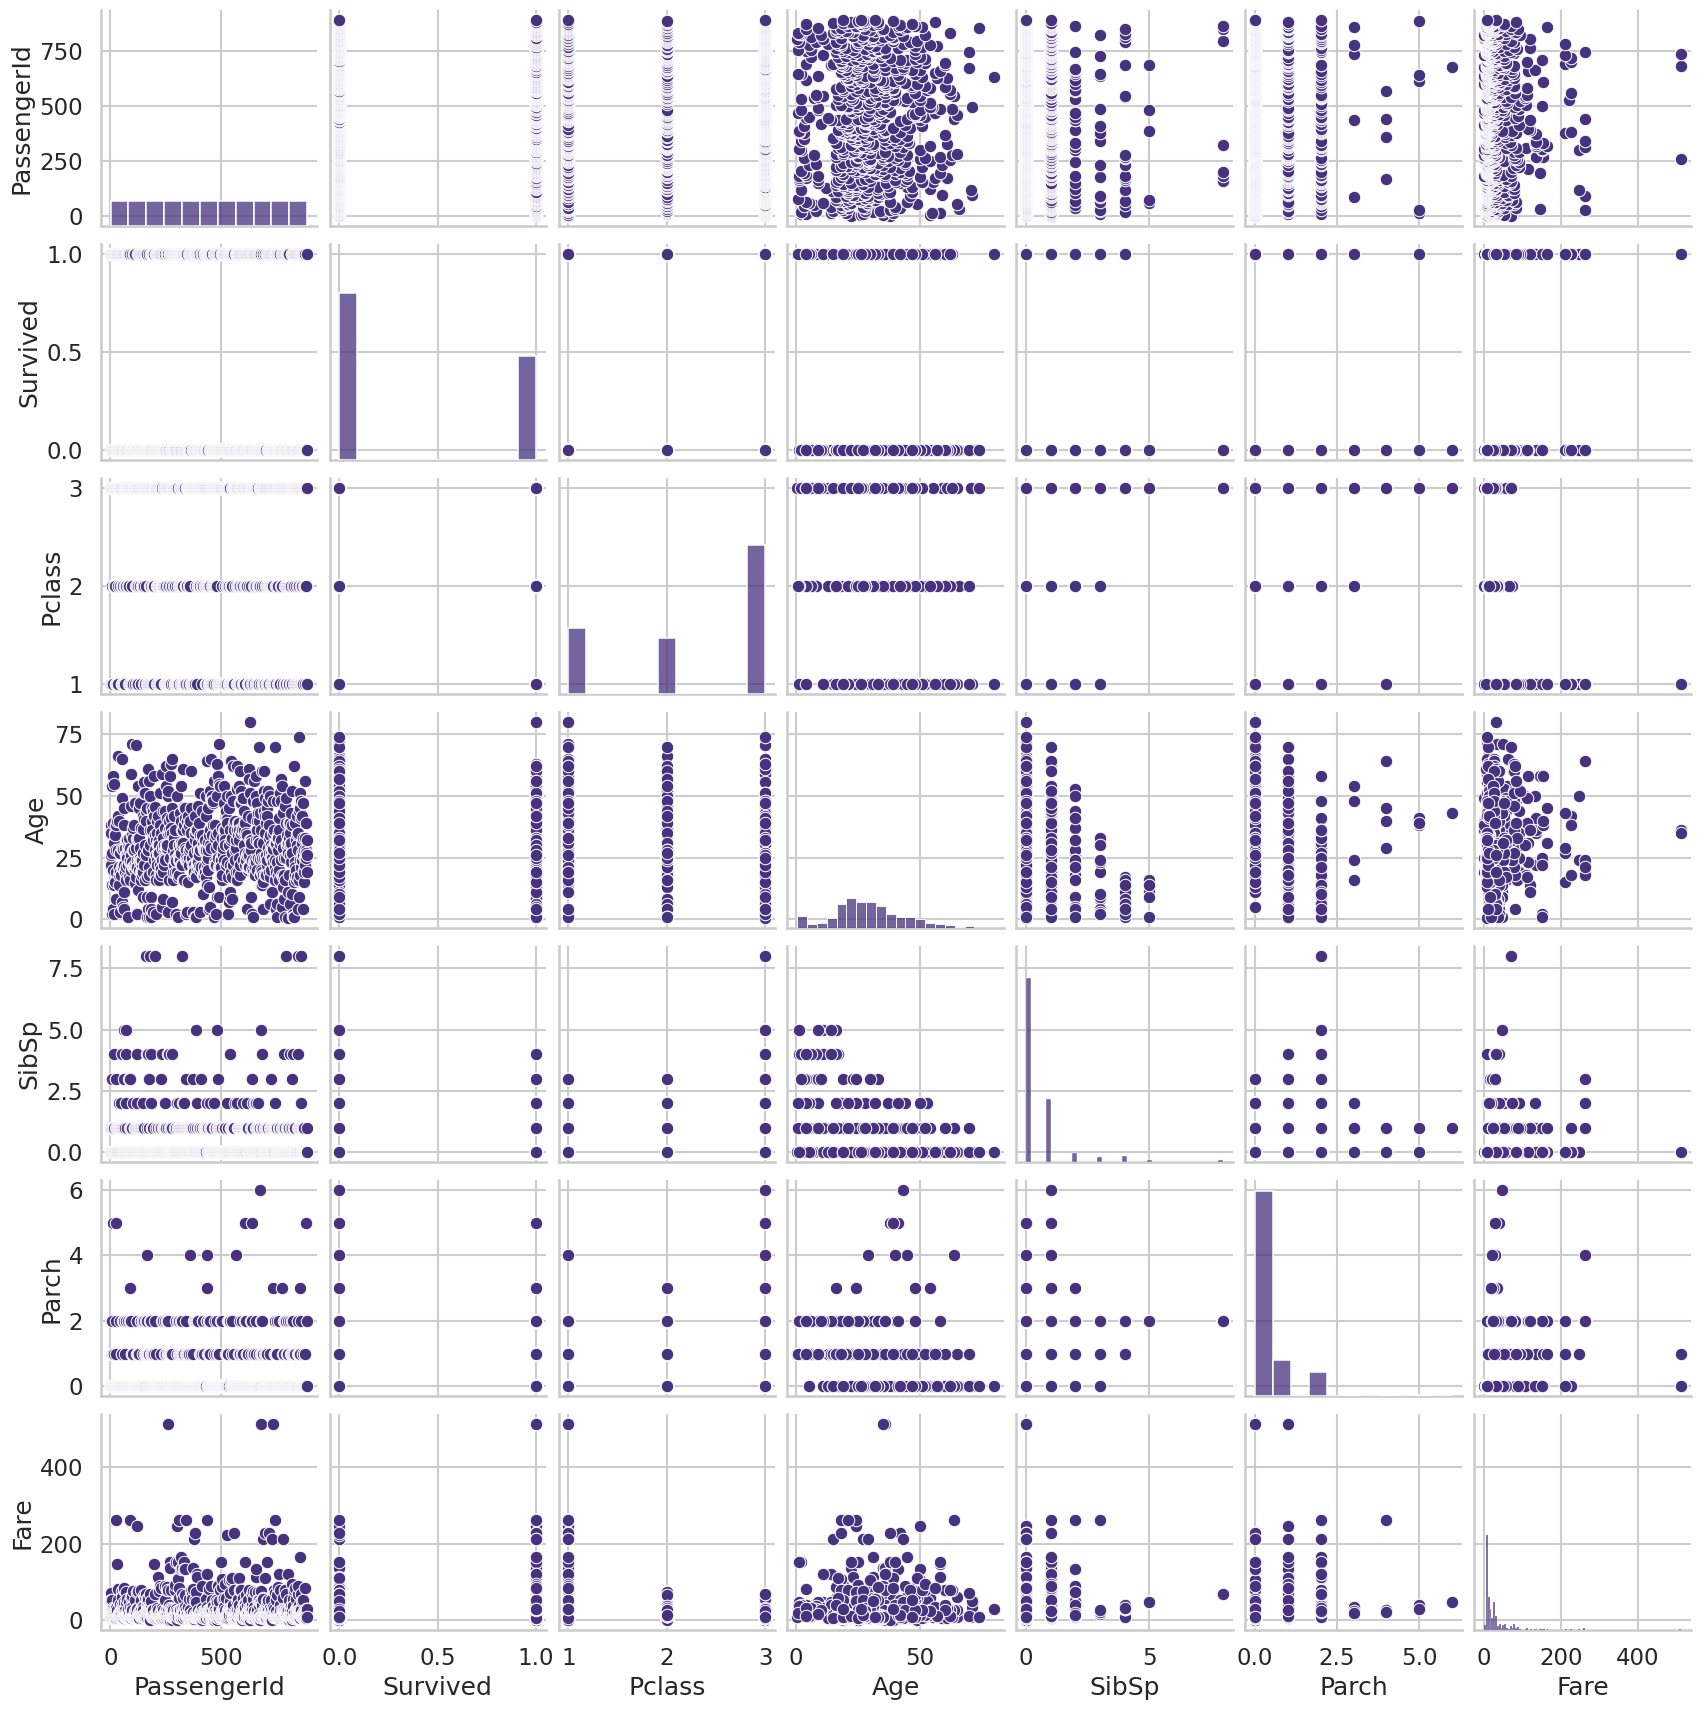

In [9]:
sns.set(style='whitegrid', context='talk', palette='viridis');
sns.pairplot(datanum)

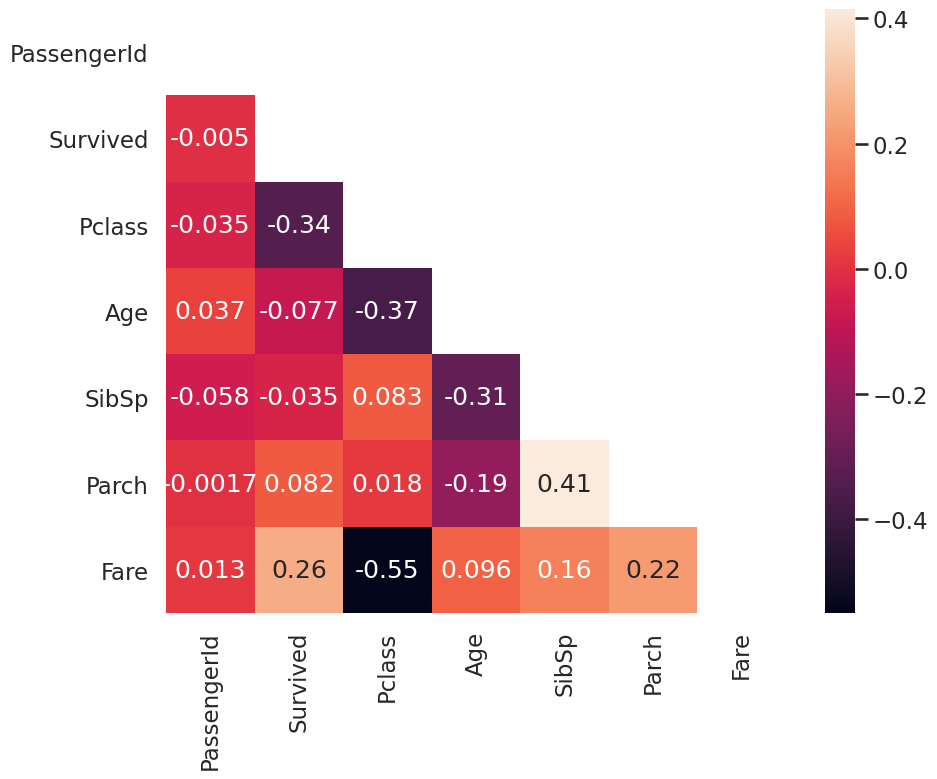

In [10]:
correlations_matrix= datanum.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

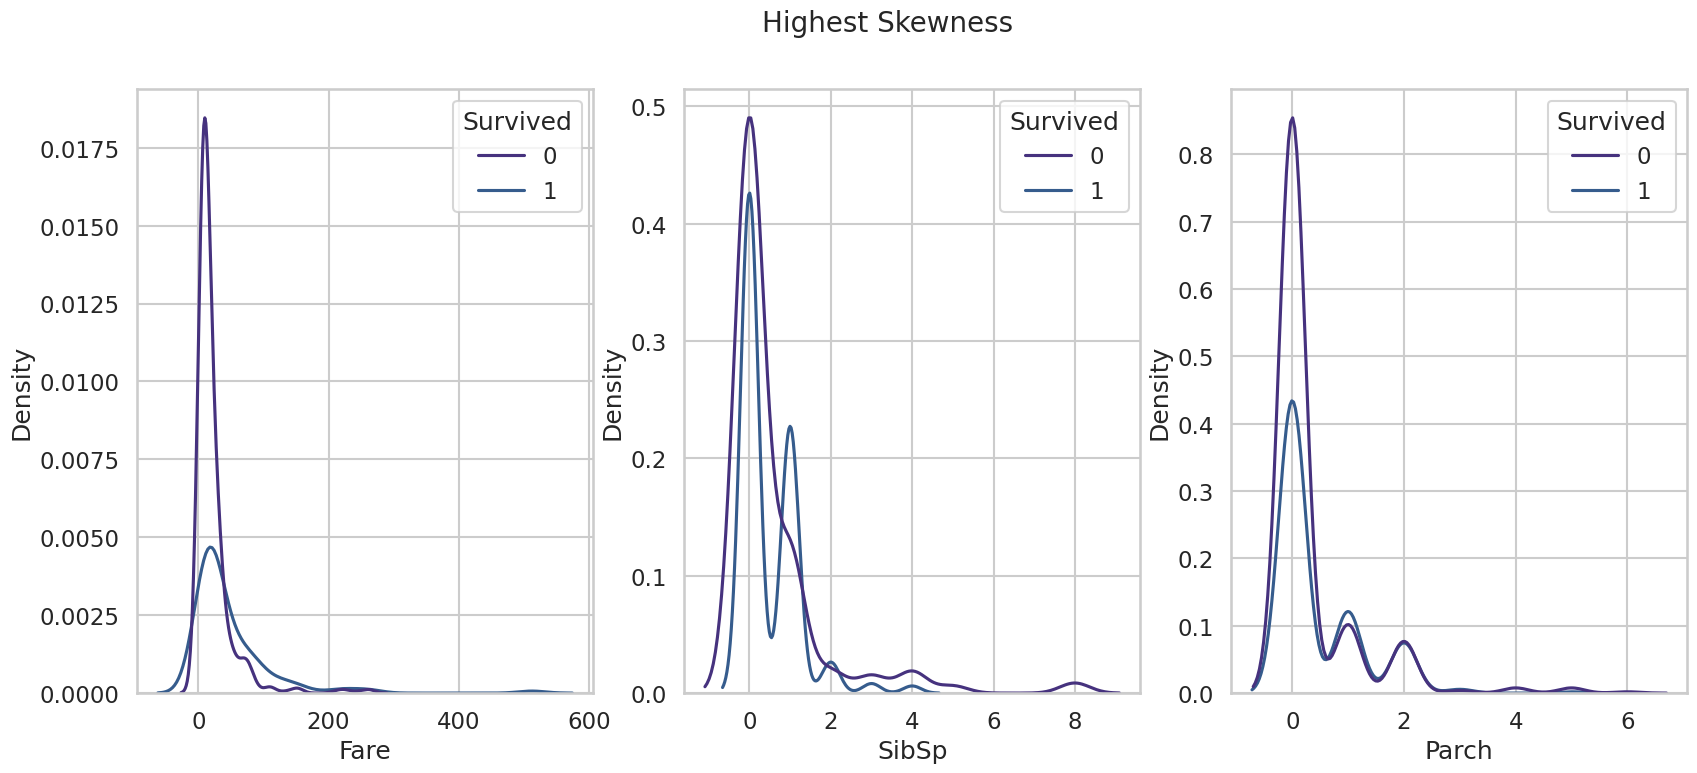

In [11]:
#Visualize columns have highest Skewness
fig, axes = plt.subplots(1,3, figsize=(20, 8));
fig.suptitle('Highest Skewness', fontsize=20);

sns.kdeplot(datanum['Fare'], ax=axes[0],hue=datanum['Survived']);
sns.kdeplot(datanum['SibSp'], ax=axes[1],hue=datanum['Survived']);
sns.kdeplot(datanum['Parch'], ax=axes[2],hue=datanum['Survived']);

### Defining three functions for plotting 

In [12]:
# lets define a function to plot a bar plot easily

def bar_plot(df,x,x_title,y,title,colors=None,text=None):
    fig = px.bar(x=x,
                 y=y,
                 text=text,
                 labels={"index": x_title},                             # replaces default labels by column name
                 data_frame=df,
                 color=colors,
                 barmode='group',
                 template="simple_white",
                 color_discrete_sequence=px.colors.qualitative.Prism)
    
    texts = [temp[col].values for col in y]
    for i, t in enumerate(texts):
        fig.data[i].text = t
        fig.data[i].textposition = 'inside'
        
    fig['layout'].title=title

    for trace in fig.data:
        trace.name = trace.name.replace('_',' ').capitalize()

    fig.update_yaxes(tickprefix="", showgrid=True)

    fig.show()

In [13]:
#lets create a function to plot a multi-violin easily

def multi_violin(df,iter_col,dist_col,color_col='survived'):
    if len(df[color_col].unique())!= 2:
        return 'Maximun number of unique values in the color columns is 2'
    i = 0
    data = []
    for ite in df[iter_col]:#multi_violin(df=df.dropna(),iter_col='pclass',dist_col='age',color_col='target')
#         print(df[df[color_col]==df[color_col].unique().tolist()[0]][dist_col])
        data.append(go.Violin(x=df[df[iter_col]==ite][iter_col],
                              y=df[df[color_col]==df[color_col].unique().tolist()[0]][dist_col],
                              name=str(df[color_col].unique().tolist()[0]),
                              jitter=0,
                              meanline={'visible':True},
                              line={"color": '#F78181'},
                              side='negative',
                              marker=dict(color= '#81F781'),
                              showlegend=(i==0)))

        data.append(go.Violin(x=df[df[iter_col]==ite][iter_col],
                              y=df[df['target']==df['target'].unique().tolist()[1]]['age'],
                               name=str(df[color_col].unique().tolist()[1]),
                               jitter=0,
                               meanline={'visible':True},
                               line={"color": '#00FF40'},
                               side='positive',
                               marker=dict(color= '#81F781'),
                               showlegend=(i==0)))
        i+=1


    layout = dict(title='Distribution of {} column for each {} colored by {}'.format(dist_col.replace('_',' ').title(),
                                                                                     iter_col.replace('_',' ').title(),
                                                                                     color_col.replace('_',' ').title()),
                  width=1000,height=600,
                  yaxis=dict(title='Distribution',titlefont=dict(size=20)))

    iplot(dict(data=data,layout=layout))  

In [14]:
#create a function to plot multi box plots easily

def multi_box(df,cat_col,dist_col,color_col):
    
    y = []
    x = []
    
    if len(df[color_col].unique())!= 2:
        return 'Maximun number of unique values in the color columns is 2'
    
    for c in set(df[cat_col].unique().tolist()):
        for t in set(df[color_col].unique()):
            y.append(df[(df[cat_col]==c) & (df[color_col]==t)][dist_col].values)
            x.append(str(c)+' ('+str(t)+')')        

    colors = ['rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
              'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
              'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)',
              'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
              'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
              'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)']

    traces = []

    for xd, yd, cls in zip(x, y, colors[:2*len(df[cat_col].unique())]):
            traces.append(go.Box(y=yd,
                                 name=xd,
                                 boxpoints='all',
                                 jitter=0.5,
                                 whiskerwidth=0.2,
                                 fillcolor=cls,
                                 marker=dict(size=2),
                                 line=dict(width=1)))

    layout = go.Layout(title='{} distribution colord by {} grouped by {}'.format(dist_col.title(),
                                                                                 color_col.title(),
                                                                                 cat_col.title()),
        xaxis=dict(title=cat_col,
                   titlefont=dict(size=16)),
        
        yaxis=dict(title='Distribution',
                   autorange=True,
                   showgrid=True,
                   zeroline=True,
                   dtick=5,
                   gridcolor='rgb(255, 255, 255)',
                   gridwidth=1,
                   zerolinecolor='rgb(255, 255, 255)',
                   zerolinewidth=2,
                   titlefont=dict(
                   size=16)),
        
        margin=dict(l=40,
                    r=30,
                    b=80,
                    t=100),
        
        paper_bgcolor='rgb(255, 255, 255)',
        plot_bgcolor='rgb(255, 243, 192)',
        showlegend=False)

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

## Categorical Variables 

### Sex 
The plot shows that most passengers are male, female have a higher chances of survival.

In [15]:
temp = pd.DataFrame()

for sex in pd.unique(data['Sex']).tolist():
    temp[sex] = data[data['Sex']==sex]['target'].value_counts()
    
temp = temp.rename(columns={0:'Female',1:'Male'}).T
temp['Total sum'] = temp.sum(axis=1)

bar_plot(temp.reset_index(),
         'index',
         'Sex',
         ['Total sum','Survived','Not Survived'],
         title='Survived and Not-survived grouped by sex')

### Passenger Class

Graph shows that most passengers were in class 3 and they are the ones less likely to survive (speculation: probably due to location of cabins?)

In [16]:
temp = pd.DataFrame()

for p in pd.unique(data['Pclass']).tolist():
    temp[p] = data[data['Pclass']==p]['target'].value_counts()
    
temp = temp.rename(columns={1:'Class 1',2:'Class 2', 3:'Class 3'}).T
temp['Total sum'] = temp.sum(axis=1)

bar_plot(temp.reset_index(),
         'index',
         'Pclass',
         ['Total sum','Survived','Not Survived'],
         title='Survived and Not-survived grouped by Pclass')


### Family Counts

Solo travellers have very low chances of survival, while people with 2-4 family members are more likely to survive. Beyond 4, more family members do not increase likelihood of survival.

In [17]:
#engineer a new column for the total number of family (Passenger )
data['family count'] = data['Parch']+data['SibSp']+1 
data['family count'] = data['family count'].astype(int)

del data['Parch']
del data['SibSp']

temp = pd.crosstab(index=data['family count'],columns=data['target']).reset_index()

temp['Total sum'] = temp.sum(axis=1)

bar_plot(temp,
         'family count',
         'Family number',
         ['Total sum','Survived','Not Survived'],
         title='Survived and Not-survived grouped by Family number')

### Embarked

Roughly 70% of people embarked from Southampton. They are less likely to survive.

In [18]:
data['Embarked'].value_counts().to_frame().rename(columns={'Embarked':'Total Count'})

Total Count
S          644
C          168
Q           77

In [19]:
temp = pd.DataFrame()

for e in data['Embarked'].unique().tolist():
    temp[e] = data[data['Embarked']==e]['target'].value_counts()
    
temp = temp.T.rename(index={'S':'Southampton','C':'Cherbourg','Q':'Queenstown'})
temp['Total sum'] = temp.sum(axis=1)

bar_plot(temp.reset_index(),
         'index',
         'Embarked',
         ['Total sum','Survived','Not Survived'],
         title='Survived and Not-survived grouped by Embarked column')

## Numerical Variables 

### Age
It is not very informative and if we need to use it as predictor, we will need quite some feature extraction and engineering

In [20]:
#enginerring a new column age_category where nans are replaced with the age mean and age is binned into ranges.
data['age_category'] = pd.cut(data['Age'].fillna(data['Age'].mean()).astype(int), bins=[-1,11,18,22,27,33,40,66,100],
                            labels=["<=11","11-18","19-22","23-27","28-33","34-40","41-66",">=67"])

temp = pd.DataFrame()
for age in data['age_category'].unique().tolist():
    temp[age] = data[data['age_category']==age]['target'].value_counts()

temp = temp.T.reset_index()
temp['Total sum'] = temp.sum(axis=1)

bar_plot(temp.reset_index(),
         'index',
         'Age Category',
         ['Total sum','Survived','Not Survived'],
         title='Survived and Not-survived grouped by Age column')


fig = make_subplots(rows=2, cols=2,
                    specs=[[{"colspan": 2}, None],
                           [{}, {}]],
                    subplot_titles=('Age ditribution',
                                    'Age ditribution (Survived)',
                                    'Age ditribution (Not Survived)'))

fig.add_trace(go.Histogram(x=data['Age']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=data[data['target']=='Survived']['Age']),
              row=2, col=1)

fig.add_trace(go.Histogram(x=data[data['target']=='Not Survived']['Age']),
              row=2, col=2)

fig.update_layout(showlegend=False, title_text='Ditribution for Age')
fig.show()

### Fare

In [21]:
fig = make_subplots(rows=2, cols=2,
                    specs=[[{"colspan": 2}, None],
                           [{}, {}]],
                    subplot_titles=('Fare ditribution',
                                    'Fare ditribution (Survived)',
                                    'Fare ditribution (Not Survived)'))

fig.add_trace(go.Histogram(x=data['Fare'][:len(train)]),
              row=1, col=1)

fig.add_trace(go.Histogram(x=data[data['target']=='Survived']['Fare'][:len(train)]),
              row=2, col=1)

fig.add_trace(go.Histogram(x=data[data['target']=='Not Survived']['Fare'][:len(train)]),
              row=2, col=2)

fig.update_layout(showlegend=False, title_text='Ditribution for Fare')
fig.show()

## Extracting more relevant information by grouping by variable of interest, hueing by target variable

In [22]:
multi_box(data.dropna(),'Pclass','Age','target')

In [23]:
multi_box(data.dropna(),'Sex','Age','target')

# Feature Engineering

In [24]:
#some tickets only have numbers and some have initial letters+numbers. 
#I assigned 'normal' to numbers only and collected all the letters.

tick=[]

for i in range(len(data['Ticket'])):
    if len(data['Ticket'][i]) < 8:
        tick.append('normal') 
    else:
        tick.append(data['Ticket'][i].split(' ')[0])
        
data['tickettype']=tick

###
#here I still want to save all numbers, so I will create a new list containing ticket numbers and replace the old one with this.
ticknum=[]

for i in range(len(data['Ticket'])):
    try:
        ticknum.append(data['Ticket'][i].split(' ')[1])
    except:
        ticknum.append(data['Ticket'][i])


data['ticket']=ticknum
data=data.drop('Ticket',axis=1)

###

for i in range(len(data['ticket'])):
    if data['ticket'][i].endswith('.'):
           data['ticket'][i]=data['ticket'][i].lstrip('.') 

In [25]:
data['Cabin']=data['Cabin'].replace(np.nan,'unknown')

for i in range(len(data['Cabin'])):
    data['Cabin'][i]=data['Cabin'][i][0]

In [26]:
data['Embarked']=data['Embarked'].replace(np.nan, str('S')) #replaced with most common embarking spot

In [27]:
#extracting the unique titles
# title_list = pd.concat([train,test])['Name'].apply(lambda x: re.findall(r'[, ]\w+[.]',x)[0][:-1]).unique()
title_list = data['Name'].apply(lambda x: re.findall(r'[, ]\w+[.]',x)[0][:-1]).unique()

# Using this iteratively I was able to get a full list of titles.
title_list = ['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms','Major', 
             'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess','Jonkheer', 'Dona']

 
# replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Rev', 'Col','Capt','Sir','Major','Jonkheer']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms','Lady','Dona']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
#create a new columns containing the title for each name
data['Title'] = data['Name'].apply(lambda x: re.findall(r'[, ]\w+[.]',x)[0][:-1])

# apply replacing title function to all titles
data['Title'] = data.apply(replace_titles, axis=1)

#delete name column,PassengerId,Ticket
del data['Name']

In [28]:
data['Age']=data['Age'].fillna(data['Age'].mean()).astype(int)

In [29]:
#lets create age category
data['age_category'] = pd.cut(data['Age'].astype(int), bins=[-1,11,18,22,27,33,40,66,100],
                            labels=[1,2,3,4,5,6,7,8]).to_frame()

# Age times Class 
#(multiplying the age category by passenger class balances differences out in terms of importance of that person onboard)
#although it should be reversed (class 1 is more important than class 3)
data['age_class'] = data['age_category']* data['Pclass']
data['age_class'] = data['age_class'].astype(int) 

# Fare per Person
data['fare_per_person'] = data['Fare']/(data['family count'])
data['fare_per_person'] = data['fare_per_person'].astype(float)  

# Is alone
#being a solo traveler decreases your chances of survival
data['is_alone'] = 0
data.loc[data['family count'] == 1, 'is_alone'] = 1

In [30]:
del data['Age']
del data['Survived']

In [31]:
data.head()

Pclass     Sex     Fare Cabin Embarked        target     sex  family count  \
0       3    male   7.2500     u        S  Not Survived    Male             2   
1       1  female  71.2833     C        C      Survived  Female             2   
2       3  female   7.9250     u        S      Survived  Female             1   
3       1  female  53.1000     C        S      Survived  Female             2   
4       3    male   8.0500     u        S  Not Survived    Male             1   

   age_category tickettype   ticket  Title  age_class  fare_per_person  \
0             3        A/5    21171     Mr          9          3.62500   
1             6         PC    17599    Mrs          6         35.64165   
2             4   STON/O2.  3101282   Miss         12          7.92500   
3             6     normal   113803    Mrs          6         26.55000   
4             6     normal   373450     Mr         18          8.05000   

   is_alone  
0         0  
1         0  
2         1  
3         0  
4         1

In [32]:
def readyML(df):
    df['family count'] = df['Parch']+df['SibSp']+1 
    df['family count'] = df['family count'].astype(int)

    del df['Parch']
    del df['SibSp']
    tick=[]

    for i in range(len(df['Ticket'])):
        if len(df['Ticket'][i]) < 8:
            tick.append('normal') 
        else:
            tick.append(df['Ticket'][i].split(' ')[0])

    df['tickettype']=tick

    ###
    #here I still want to save all numbers, so I will create a new list containing ticket numbers and replace the old one with this.
    ticknum=[]

    for i in range(len(df['Ticket'])):
        try:
            ticknum.append(df['Ticket'][i].split(' ')[1])
        except:
            ticknum.append(df['Ticket'][i])


    df['ticket']=ticknum
    df=df.drop('Ticket',axis=1)

    ###

    for i in range(len(df['ticket'])):
        if df['ticket'][i].endswith('.'):
               df['ticket'][i]=df['ticket'][i].lstrip('.') 
    df['Cabin']=df['Cabin'].replace(np.nan,'unknown')

    for i in range(len(df['Cabin'])):
        df['Cabin'][i]=df['Cabin'][i][0]
        
    df['Embarked']=df['Embarked'].replace(np.nan, str('S'))
    
    title_list = df['Name'].apply(lambda x: re.findall(r'[, ]\w+[.]',x)[0][:-1]).unique()
    
    def replace_titles(x):
        title=x['Title']
        if title in ['Don', 'Rev', 'Col','Capt','Sir','Major','Jonkheer']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms','Lady','Dona']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title

    #create a new columns containing the title for each name
    df['Title'] = df['Name'].apply(lambda x: re.findall(r'[, ]\w+[.]',x)[0][:-1])

    # apply replacing title function to all titles
    df['Title'] = df.apply(replace_titles, axis=1)

    #delete name column,PassengerId,Ticket
    del df['Name']
    df['Age']=df['Age'].fillna(df['Age'].mean()).astype(int)

    df['age_category'] = pd.cut(df['Age'].astype(int), bins=[-1,11,18,22,27,33,40,66,100],
                                labels=[1,2,3,4,5,6,7,8]).to_frame()

    # Age times Class 
    #(multiplying the age category by passenger class balances differences out in terms of importance of that person onboard)
    #although it should be reversed (class 1 is more important than class 3)
    df['age_class'] = df['age_category']* df['Pclass']
    df['age_class'] = df['age_class'].astype(int) 

    # Fare per Person
    df['fare_per_person'] = df['Fare']/(df['family count'])
    df['fare_per_person'] = df['fare_per_person'].astype(float)  

    # Is alone
    #being a solo traveler decreases your chances of survival
    df['is_alone'] = 0
    df.loc[df['family count'] == 1, 'is_alone'] = 1
    del df['Age']
    
    return df

In [33]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [34]:
test=readyML(test)

In [35]:
test.head()

PassengerId  Pclass     Sex     Fare Cabin Embarked  family count  \
0          892       3    male   7.8292     u        Q             1   
1          893       3  female   7.0000     u        S             2   
2          894       2    male   9.6875     u        Q             1   
3          895       3    male   8.6625     u        S             1   
4          896       3  female  12.2875     u        S             3   

  tickettype   ticket Title  age_category  age_class  fare_per_person  \
0     normal   330911    Mr             6         18         7.829200   
1     normal   363272   Mrs             7         21         3.500000   
2     normal   240276    Mr             7         14         9.687500   
3     normal   315154    Mr             4         12         8.662500   
4     normal  3101298   Mrs             3          9         4.095833   

   is_alone  
0         1  
1         0  
2         1  
3         1  
4         0

In [36]:
data.head()

Pclass     Sex     Fare Cabin Embarked        target     sex  family count  \
0       3    male   7.2500     u        S  Not Survived    Male             2   
1       1  female  71.2833     C        C      Survived  Female             2   
2       3  female   7.9250     u        S      Survived  Female             1   
3       1  female  53.1000     C        S      Survived  Female             2   
4       3    male   8.0500     u        S  Not Survived    Male             1   

   age_category tickettype   ticket  Title  age_class  fare_per_person  \
0             3        A/5    21171     Mr          9          3.62500   
1             6         PC    17599    Mrs          6         35.64165   
2             4   STON/O2.  3101282   Miss         12          7.92500   
3             6     normal   113803    Mrs          6         26.55000   
4             6     normal   373450     Mr         18          8.05000   

   is_alone  
0         0  
1         0  
2         1  
3         0  
4         1

In [37]:
del data['Sex']

# Data Preparation for ML

In [38]:
Y = data['target']
X = data.drop('target', axis=1)

In [39]:
X_num=X.select_dtypes(include=np.number)
X_cat=X.select_dtypes(exclude=np.number)

#scaling the numerical columns
from sklearn.preprocessing import StandardScaler 
fitted = StandardScaler().fit(X_num)
x_scaled = fitted.transform(X_num)
print(x_scaled.shape)
x_scaled=pd.DataFrame(x_scaled)

#encoding the categoricals
encoded=pd.get_dummies(X_cat, drop_first=True)
type(encoded)

X = np.concatenate((x_scaled, encoded), axis=1)
pd.DataFrame(X).head()
X.shape

(891, 7)


(891, 739)

In [40]:
#split the data with train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [41]:
#building the model object
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

#fitting it with train data and predicting using testX
lr_model.fit(X_train, y_train)
Y_pred = lr_model.predict(X_test) 

In [42]:
def Score_Analisis(classification, X_test, y_test): #Function that tests the prediction of Logistic models with a variety of parameters
    predictions = classification.predict(X_test) 
    print("Accuracy score: %4.2f " % accuracy_score(y_test, predictions))
    print("Precision score : %4.2f" % (precision_score(y_test,predictions,pos_label='Survived')))
    print("Recall score : %4.2f" % (recall_score(y_test,predictions,pos_label='Survived')))
    print("F1-score : %4.2f" % (f1_score(y_test,predictions,pos_label='Survived')))
    #print("Kappa score : %4.2f" % (cohen_kappa_score(y_test, predictions)))
    #print(classification_report(y_test, predictions, labels=['No', 'Yes'], zero_division = 1))
    plot_confusion_matrix(classification, X_test, y_test) 
    plt.show()

Accuracy score: 0.84 
Precision score : 0.81
Recall score : 0.80
F1-score : 0.80


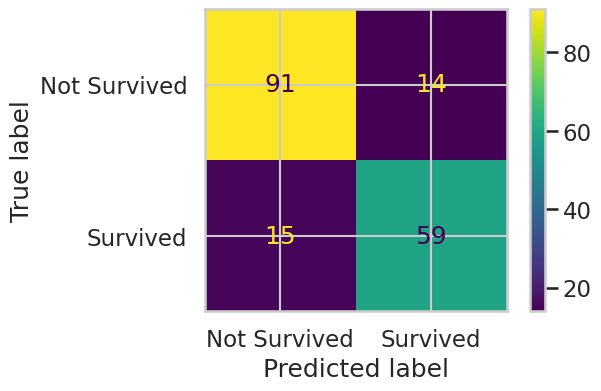

In [43]:
Score_Analisis(lr_model, X_test, y_test)

In [44]:
rfc = RandomForestClassifier().fit(X_train, y_train)

Accuracy score: 0.84 
Precision score : 0.83
Recall score : 0.77
F1-score : 0.80


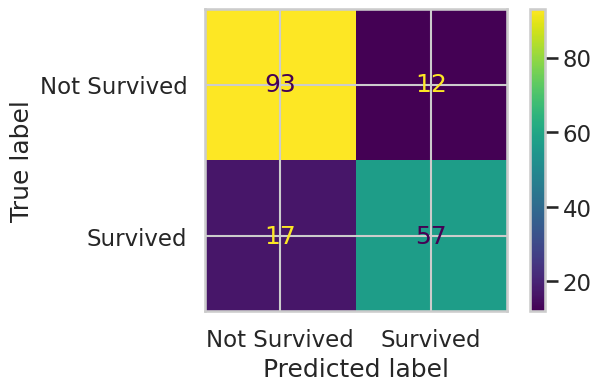

In [45]:
Score_Analisis(rfc, X_test, y_test)